# Spiking neural networks for EMG data streaming

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


import os
import sys
sys.path.append("..")
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/s2net-emg")
'''
!pip install librosa==0.9.1
!pip install pandas
!pip install numpy==1.21.4
!pip install numba==0.53.0
!pip install scipy
!pip install torch
!pip install torchvision
!pip install matplotlib
'''

import scipy
from scipy import signal
import time
import numpy as np
import librosa
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision


from utils import plot_spk_rec, plot_mem_rec
from models import SNN, SpikingConv2DLayer, ReadoutLayer, SurrogateHeaviside, SpikingDenseLayer

from data import EMGDataset, PSD, RMS, FMD, MMDF, MAV, Rescale
from optim import RAdam

Mounted at /content/drive


In [24]:
# Different feature extraction functions
# 0 - FMD
# 1 - MAV
# 2 - MMDF
# 3 - RMS
# 4 - PSD
MODE = 1
# Use bottleneck structure?
BOTTLENECK = False

In [25]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading Data

In [26]:
train_data_root = "/content/drive/MyDrive/Colab Notebooks/s2net-emg/data4/train"
test_data_root = "/content/drive/MyDrive/Colab Notebooks/s2net-emg/data4/test"

training_words = os.listdir(train_data_root)
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x))]
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x)) if x[0] != "_" ]
print("{} training words:".format(len(training_words)))
print(training_words)

8 training words:
['3', '4', '6', '7', '1', '5', '8', '2']


In [27]:
testing_words = os.listdir(test_data_root)
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x))]
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x)) 
                 if x[0] != "_"]
print("{} testing words:".format(len(testing_words)))
if len(testing_words) != len(training_words):
    raise ValueError("Mismathed data")
print(testing_words)

8 testing words:
['4', '2', '7', '5', '1', '8', '3', '6']


In [28]:
# Using labels from datasets
lb = sorted(testing_words)
label_dct = {lb[i]: i for i in range(len(lb))}
if len(testing_words) != len(label_dct.keys()):
    raise ValueError("Mismathed data")
print("label_dct:")
print(label_dct)

label_dct:
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7}


In [29]:
sr = 150
size = 150
n_fft = size
window = 150

In [30]:
rms = RMS(window)
psd = PSD(sr, n_fft, window)
fmd = FMD()
mmdf = MMDF()
mav = MAV()
rescale = Rescale()
init_channels = 1
init_shape = 8


if MODE == 0:
    transform = torchvision.transforms.Compose([fmd, rescale])
elif MODE == 1:
    transform = torchvision.transforms.Compose([mav, rescale])
elif MODE == 2:
    transform = torchvision.transforms.Compose([mmdf, rescale])
elif MODE == 3:
    transform = torchvision.transforms.Compose([rms, rescale])
elif MODE == 4:
    transform = torchvision.transforms.Compose([psd, rescale])
else:
    print("Incorect mode, using MAV")
    transform = torchvision.transforms.Compose([mav, rescale])


def collate_fn(data):
    
    X_batch = np.array([d[0] for d in data])
    std = X_batch.std(axis=(0,3), keepdims=True)
    X_batch = torch.tensor(X_batch/std)
    
    y_batch = torch.tensor([d[1] for d in data])
    
    return X_batch, y_batch 
 

In [31]:
batch_size = 20

train_dataset = EMGDataset(train_data_root, label_dct, transform = transform, mode="train", max_nb_per_class=None)
train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.weights,len(train_dataset.weights))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler, collate_fn=collate_fn)

test_dataset = EMGDataset(test_data_root, label_dct, transform = transform, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Creating the model

In [32]:
spike_fn = SurrogateHeaviside.apply

w_init_std = 0.15
w_init_mean = 0.

main_channels = 32 
bottleneck = 64

#ORIGINAL ARCH
if BOTTLENECK:
    layers = []
    in_channels = init_channels
    out_channels = main_channels
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = init_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True))


    in_channels = main_channels
    out_channels = 48
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = output_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True))


    in_channels = 48
    out_channels = 64
    kernel_size = (5,5)
    dilation = (1,1)
    input_shape = output_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True, stride=(1,1)))


    in_channels = 64
    out_channels = main_channels
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = output_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, flatten_output=True))
else:
    layers = []
    in_channels = init_channels
    out_channels = main_channels
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = init_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True))


    in_channels = main_channels
    out_channels = main_channels
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = output_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True))


    in_channels = main_channels
    out_channels = main_channels 
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = output_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True))


    in_channels = main_channels
    out_channels = main_channels
    kernel_size = (1,1)
    dilation = (1,1)
    input_shape = output_shape
    output_shape = input_shape # padding mode is "same"
    layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, flatten_output=True))
    

# previous layer output has been flattened
input_shape = output_shape*out_channels
output_shape = 8
time_reduction="mean" #mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

X_batch, _ = next(iter(train_dataloader))
X_batch = X_batch.to(device, dtype)
snn(X_batch)

for i,l in enumerate(snn.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))

Layer 0: average number of spikes=0.4387
Layer 1: average number of spikes=0.2848
Layer 2: average number of spikes=0.2564
Layer 3: average number of spikes=0.2484


# Training and plotting

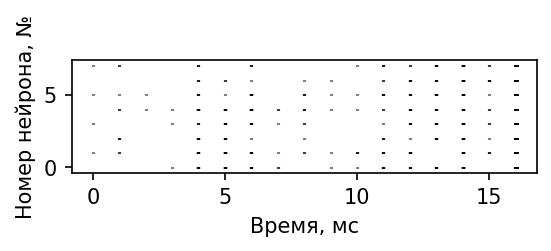

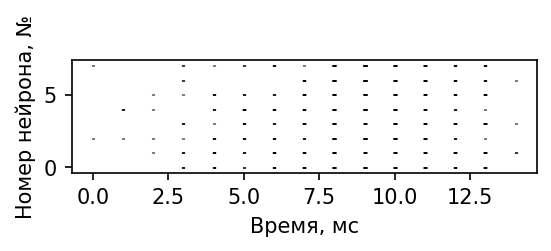

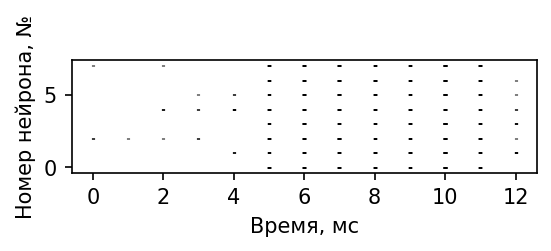

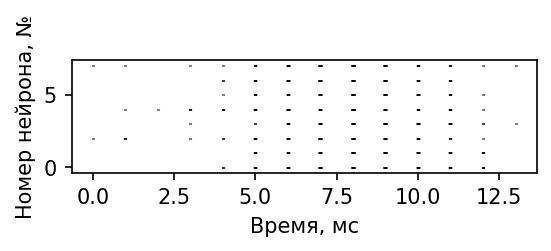

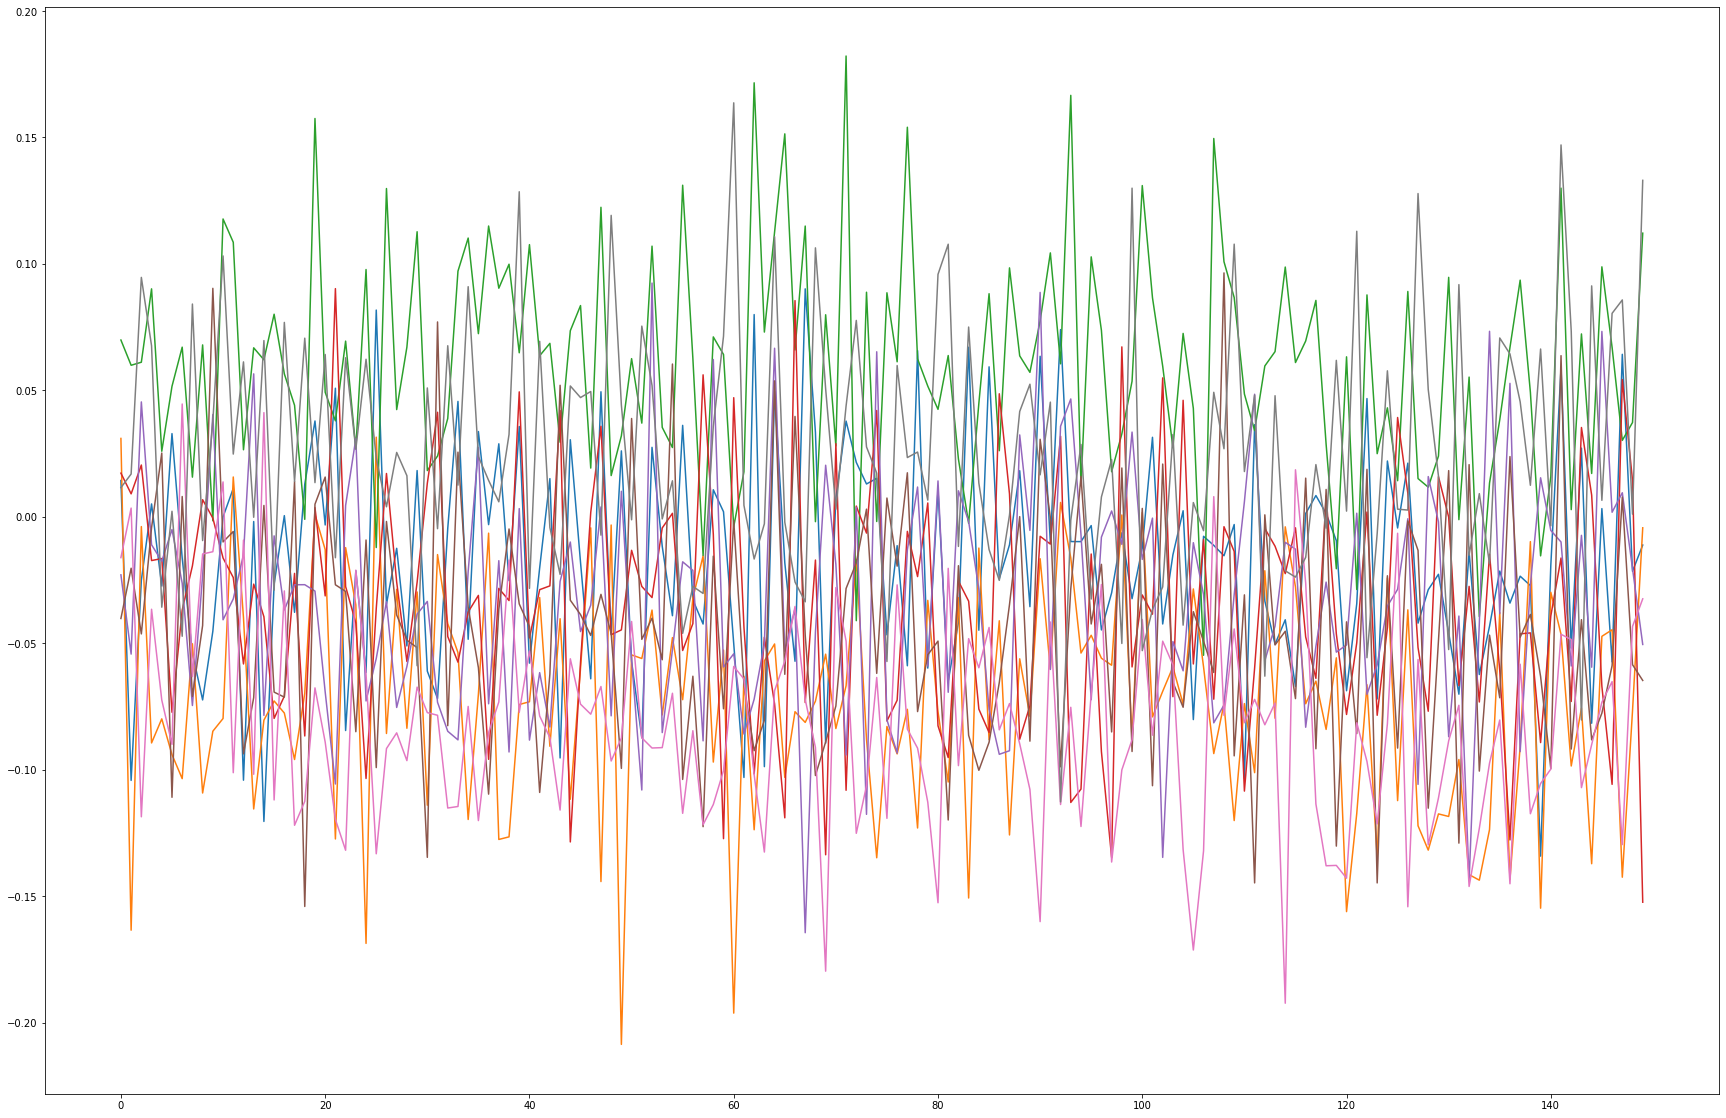

In [33]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
def plot_spk_rec(spk_rec, idx):
    

    nb_plt = len(idx)
    d = int(np.sqrt(nb_plt))
    gs = GridSpec(d,d)
    fig= plt.figure(figsize=(30,20),dpi=150)
    for i in range(nb_plt):
        plt.subplot(gs[i])
        #plt.imshow(spk_rec[idx[i]].T,cmap=plt.cm.gray_r, origin="lower", aspect='auto')
        plt.eventplot(spk_rec[idx[i]].T, lineoffsets=1, linelengths=0.05, colors='black')
        #plt.show()
        fig.set_figwidth(4)
        fig.set_figheight(1)
        plt.xlabel("Время, мс")
        plt.ylabel("Номер нейрона, №")    

nb_plt = 1

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [ ]:
def train(model, params, optimizer, train_dataloader, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= len(train_dataloader)*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[]}
    for e in range(nb_epochs):
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        for x_batch, y_batch in train_dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)

            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

            for i,loss in enumerate(loss_seq[:-1]):
                reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
                loss_val += reg_loss_val
                reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()

            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        

    return hist
        
def compute_classification_accuracy(model, dataloader):
    accs = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
    return np.mean(accs)

In [ ]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1
nb_epochs = 10
warmup_epochs = 1

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(snn, params, optimizer, train_dataloader, reg_loss_coef, nb_epochs=nb_epochs,
                    scheduler=scheduler, warmup_epochs=1)


KeyboardInterrupt: ignored

In [ ]:
test_accuracy = compute_classification_accuracy(snn, test_dataloader)
print("Test accuracy=%.3f"%(test_accuracy))

In [ ]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)